In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [1]:
# Import relevant modules
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from matplotlib import pyplot as plt

# The following lines adjust the granularity of reporting.
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

# The following line improves formatting when ouputting NumPy arrays.
np.set_printoptions(linewidth = 200)

from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.optimizers import Adam
import os
import cv2

In [3]:
df = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
df

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
from sklearn.model_selection import train_test_split

# Extract image data and labels
X = df.iloc[:, 1:].values.reshape(-1, 28, 28)  # Reshape to 28x28 images
y = df['label'].values  # Labels

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]} images")
print(f"Validation set size: {X_val.shape[0]} images")

Training set size: 33600 images
Validation set size: 8400 images


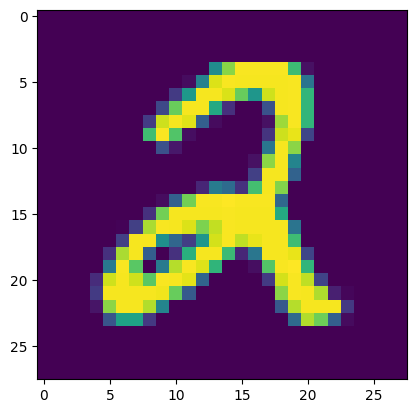

In [5]:
plt.imshow(X_train[100])

In [6]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((33600, 28, 28), (8400, 28, 28), (33600,), (8400,))

In [7]:
# Output pixel #16 of row #10 of example #5000.
X_train[5000][15][16]

240

In [8]:
unique_labels, counts = np.unique(y_train, return_counts=True)

# Print unique labels and their counts
for label, count in zip(unique_labels, counts):
    print(f"Class {label}: {count} samples")


Class 0: 3316 samples
Class 1: 3775 samples
Class 2: 3331 samples
Class 3: 3414 samples
Class 4: 3233 samples
Class 5: 3093 samples
Class 6: 3352 samples
Class 7: 3508 samples
Class 8: 3228 samples
Class 9: 3350 samples


=> Almost balanced dataset

In [9]:
def apply_clahe_norm(images):
    processed = []
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    for img in images:
        img = clahe.apply(img.astype(np.uint8))        # Apply CLAHE
        img = img.astype(np.float32) / 255.0           # Normalize to [0,1]
        processed.append(img)
    return np.expand_dims(np.array(processed), -1)     # Add channel dim

X_train = apply_clahe_norm(X_train)
X_val = apply_clahe_norm(X_val)

In [10]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.models import Sequential

# Update the model to use the new preprocessing function
model = Sequential([
    Input(shape=(28, 28, 1)),  # Input shape for grayscale images
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])


# Print the model summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 421,642 (1.61 MB)

 Trainable params: 421,642 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Define the callbacks
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model with callbacks
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_val, y_val), callbacks=[checkpoint, 
                                                                                                           early_stopping, 
                                                                                                           reduce_lr,
                                                                                                           ])

Epoch 1/20
524/525 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8403 - loss: 0.5183
Epoch 1: val_loss improved from inf to 0.09216, saving model to best_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 23s 41ms/step - accuracy: 0.8406 - loss: 0.5172 - val_accuracy: 0.9724 - val_loss: 0.0922 - learning_rate: 0.0010
Epoch 2/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9790 - loss: 0.0692
Epoch 2: val_loss improved from 0.09216 to 0.05529, saving model to best_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 20s 38ms/step - accuracy: 0.9790 - loss: 0.0692 - val_accuracy: 0.9815 - val_loss: 0.0553 - learning_rate: 0.0010
Epoch 3/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9859 - loss: 0.0462
Epoch 3: val_loss improved from 0.05529 to 0.05102, saving model to best_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 19s 37ms/step - accuracy: 0.9859 - loss: 0.0462 - val_accuracy: 0.9836 - val_loss: 0.0510 - learning_rate: 0.0010
Epoch 4/20
524/525 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accu

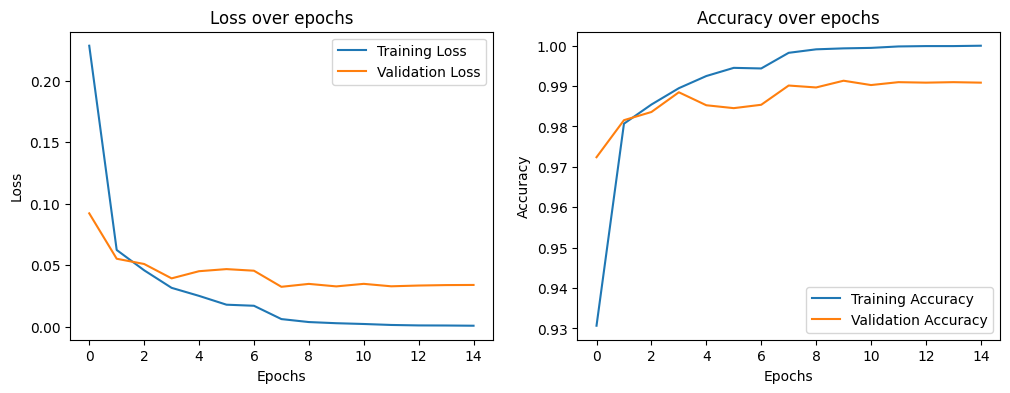

In [12]:
# plot the training and validation loss and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [14]:
X_test = pd.read_csv('/kaggle/input/digit-recognizer/test.csv').values.reshape(-1, 28, 28)
X_test = apply_clahe_norm(X_test)
X_test.shape

(28000, 28, 28, 1)

In [19]:
best_model = tf.keras.models.load_model('best_model.keras')
best_model.evaluate(X_val, y_val, verbose=2)
predictions = best_model.predict(X_test)
predictions

263/263 - 2s - 8ms/step - accuracy: 0.9901 - loss: 0.0325
875/875 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step


array([[2.7791437e-14, 2.1618681e-12, 9.9999994e-01, ..., 1.1274280e-09, 6.9987675e-11, 5.1352293e-13],
       [9.9999732e-01, 7.4716676e-13, 2.1465783e-06, ..., 4.1816683e-09, 1.5967410e-07, 1.8293294e-08],
       [7.4497067e-12, 1.7401762e-10, 7.8803964e-07, ..., 2.4789779e-08, 1.4557868e-06, 9.9994868e-01],
       ...,
       [9.5824948e-21, 1.6143237e-15, 2.8911352e-15, ..., 5.2080827e-14, 3.3109501e-11, 3.1332586e-13],
       [1.1421210e-09, 1.3338942e-10, 4.4605375e-10, ..., 1.0026411e-06, 4.1574608e-06, 9.9960226e-01],
       [1.3599421e-14, 8.2485952e-14, 9.9999994e-01, ..., 2.3324252e-11, 3.2989842e-08, 3.3010107e-12]], dtype=float32)

In [20]:
predictions = np.argmax(predictions, axis=1)
len(predictions)

28000

In [21]:
predictions = pd.Series(predictions,name="Label")
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),predictions],axis = 1)

submission.to_csv("cnn_mnist_submission.csv",index=False)
submission

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9


In [ ]:
# pd.read_csv("kaggle/input/sample_submission.csv")